In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [33]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.RandomCrop(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


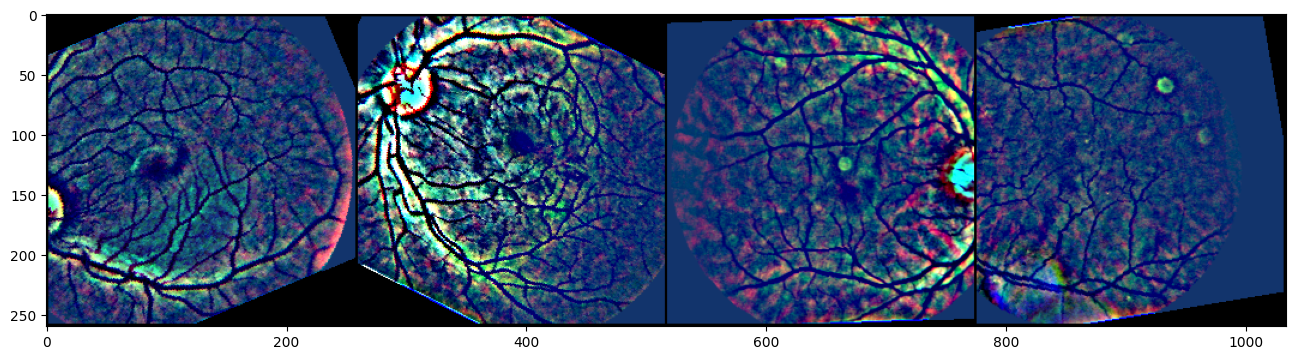

In [12]:
samples, labels = next(iter(dataloaders['train']))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples)
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [13]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
num_ftrs = model_ft.classifier.in_features

model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  len(class_names)))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                pred = torch.argmax(outputs, dim=1)
                correct = pred.eq(labels)
                running_corrects += torch.sum(correct.float())
                torch.cuda.empty_cache() ####???????

            epoch_loss = running_loss  / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc.item())
            else:
                valid_loss_list.append(epoch_loss)
                valid_acc_list.append(epoch_acc.item())                           
            plint = phase if phase == 'train' else 'valid'
            print(f'{plint} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    xepoch = np.arange(num_epochs, dtype=int)+1
    plt.plot(xepoch, train_loss_list, 'b', label='train_lossloss')
    plt.plot(xepoch, train_acc_list, 'r', label='train_lossaccuracy')
    plt.plot(xepoch, valid_loss_list, 'b--', label='valid_loss')
    plt.plot(xepoch, valid_acc_list, 'r--', label='valid_accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.title('loss and accuracy')
    plt.tick_params(axis='x')
    plt.tick_params(axis='y')
    plt.show()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
def test_model(model):    
    was_training = model.training
    model.eval()
    test_acc = 0
    for i, data in enumerate(dataloaders['test'], 0):
        samples, labels = data
        with torch.no_grad():
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            test_acc += torch.sum(correct.float())
            torch.cuda.empty_cache()
            model.train(mode=was_training)
    print('Testing Accuracy: {:.2f} %'.format(100*test_acc/dataset_sizes['test']))

Epoch [1/25]
train Loss: 0.7132 Acc: 0.5060
valid Loss: 0.6893 Acc: 0.5000
Epoch [2/25]
train Loss: 0.7107 Acc: 0.4940
valid Loss: 0.6667 Acc: 0.6250
Epoch [3/25]
train Loss: 0.6152 Acc: 0.6627
valid Loss: 0.6592 Acc: 0.6250
Epoch [4/25]
train Loss: 0.5758 Acc: 0.6988
valid Loss: 0.6832 Acc: 0.5833
Epoch [5/25]
train Loss: 0.3786 Acc: 0.8554
valid Loss: 0.6789 Acc: 0.6250
Epoch [6/25]
train Loss: 0.4218 Acc: 0.8072
valid Loss: 0.6452 Acc: 0.6667
Epoch [7/25]
train Loss: 0.4064 Acc: 0.8072
valid Loss: 0.5708 Acc: 0.6667
Epoch [8/25]
train Loss: 0.4686 Acc: 0.7952
valid Loss: 0.5464 Acc: 0.7083
Epoch [9/25]
train Loss: 0.3387 Acc: 0.8434
valid Loss: 0.5426 Acc: 0.7500
Epoch [10/25]
train Loss: 0.3071 Acc: 0.8916
valid Loss: 0.5004 Acc: 0.8333
Epoch [11/25]
train Loss: 0.2878 Acc: 0.8916
valid Loss: 0.5099 Acc: 0.7917
Epoch [12/25]
train Loss: 0.2886 Acc: 0.8916
valid Loss: 0.5183 Acc: 0.7917
Epoch [13/25]
train Loss: 0.2065 Acc: 0.9398
valid Loss: 0.5432 Acc: 0.7083
Epoch [14/25]
train L

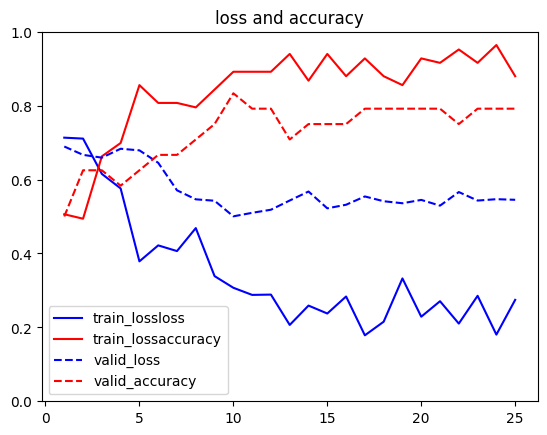

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\_utils\fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\_utils\collate.py", line 264, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\_utils\collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\_utils\collate.py", line 161, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
test_model(model_ft)

In [34]:
test_model(model_ft)

RuntimeError: DataLoader worker (pid(s) 19276, 19760, 19012, 4772) exited unexpectedly

In [31]:
# torch.save(model_ft.state_dict(), 'models/dens_4b_40e_24m.pt')

# model_ft = model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# num_ftrs = model_ft.classifier.in_features
# model_ft.classifier  = nn.Linear(num_ftrs, len(class_names))
# model_ft.load_state_dict(torch.load('models/dens_4b_24e_17m.pt'))

torch.cuda.empty_cache()